In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 4 (Wednesday), Supplementary Exercises, AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Michael Steinbach <stei0062@umn.edu>, Nico Adams adams900@umn.edu


With contributions totally ripped off from Gautham Narayan (UIUC)

## Big Picture: Bayesian Statistics

* Bayesians make statements about the probability of parameters conditional on the dataset $D$ that you actually observed

# $$p(\theta|D)$$

* This requires an interpretation of probability as a quantifying degree of belief in a hypothesis. This exists without any data even - i.e. **the prior**
    * Credible regions - arguments are based on variables you wish you observed but didn't (nuisance parameters/latent variables) 

## Big Picture: MCMC

* The Bayesian answer is the full posterior density, quantifying the "state of knowledge" after seeing the data
    * The likelihood is not a probability density in the parameters.
        * But multiply by a prior (even flat) and the posterior is a probability that obeys clear rules:
            * Conditional/Marginal probability
* **Numerical estimates (such as samples using Monte Carlo methods) are attempts to (imperfectly) summarize the posterior**
    * These techniques give us ways to deal with high-dimensional spaces e.g. many latent variables
        * Convert messy integrals to simple sums over samples
            * **All those frequentist statistics/estimators are still useful given MCMC samples!**

    
## Advice: MCMC

* MCMC is a terrible optimizer. If you just want the "best-fit", some local/global optimizer is often quicker.
    * These are often useful for reasonable starting guesses
    * Bayesians will often need to introduce latent variables/nuisance parameters/things you don't observe but wish you did 
      * Coming up with the likelihood is not the same as writing down the model
    * These parameters make the problem very high dimensional, even if you don't care about them
    * The point of it is to sample the full posterior distribution so you have reasonable **credible regions**
        * You are scientists and this is what you actually want
            * **You write down the model and likelihood, and the Bayesian framework tells you what distribution of parameters is feasible given your data and your prior belief**

## Posterior-predictive checks

* Nothing about the Bayesian framework we've discussed tells us if our model is right
    * MCMC can give us very precise, but very wrong inferences, if the model itself is inadequate
     
     
Let's look at the posterior again
## $$ P(\theta|D) \mathrm{\; is \; really \;} P(\theta|D, H) $$ 
i.e. assuming the hypothesis $H$ is itself correct.

## Posterior-predictive checks

Frequentists have a way to express the question we're asking

## $$P(D|H)$$
i.e. "how likely is the data given the hypothesis", which is similar to but not exactly the same as  "how likely is the data given the model parameters of this hypothesis"

The two are related though!

## $$P(D|H) = \int_{\theta} P(D|\theta) \cdot P(\theta|H)$$

This is the **predictive distribution** - the distribution of imaginary datasets if the hypothesis/model is true.

* i.e. if you have some observations $y_D$, and you can infer a model and then ask what we would expect to see in hypothetical replications of the same experiment.

* if the model is right, you expect to see something similar to what you did the first time

## Posterior-predictive checks

* THIS IS A FREQUENTIST IDEA!
* The idea is to generate data from the model using parameters from draws from the posterior.

## Big picture

* Bayes theory is needed to *estimate* parameters, conditional on observations and a model we are considering
* Frequentist theory is needed to *critique* a model conditioned on the data we observe, by exploring if the model actually is *likely* to generate data like our observations in the first place

## In Class Exercise:

We'll use our data from HW2 to try posterior predictive checks on a simple linear model.

In [5]:
# RUN THIS

%matplotlib inline
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import scipy.optimize
from astroML.datasets import fetch_hogg2010test
import pymc3 as pm

In [6]:
# AND THIS

# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

# convert the data to numpy arrays
x  = np.array(x)
y  = np.array(y)
dy = np.array(dy)

<ErrorbarContainer object of 3 artists>

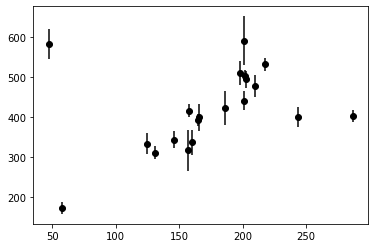

In [7]:
# We can check that the data is what we've already seen
# And you should definitely be looking at this and making a 
# qualitative comparison to the Cepheid data on your midterm
plt.errorbar(x, y, yerr=dy, linestyle='None', color='k', marker='o')

# Next, we're going to use `pymc3` to fit this model, but we're going to be naive and use a Gaussian likelihood, despite knowing there are outliers.

In [8]:
with pm.Model() as model:
    # write down expressions for the priors on the slope and intercept of the line 
    
    # https://docs.pymc.io/api/distributions/continuous.html
    # they are all in the form of 
    # Distribution('variable name', parameters of distribution)
    # e.g. Normal('blah', mu=0, sigma=1)
    m = pm.Normal('m', mu=2, sigma=5)
    b = pm.Normal('b', mu=60, sigma=70)

    # write down your model
    ymod = m*x + b

    
    # and write down your likelihood function
    # pymc3 accepts keywords, observed for the data
    likelihood = pm.Normal('likelihood', mu=ymod, sigma=dy, observed=y)

    
    # and then to sample!
    samples_ols = pm.sample(5000, cores=2) # draw 5000 posterior samples 

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


# Next make a traceplot of your samples

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>]], dtype=object)

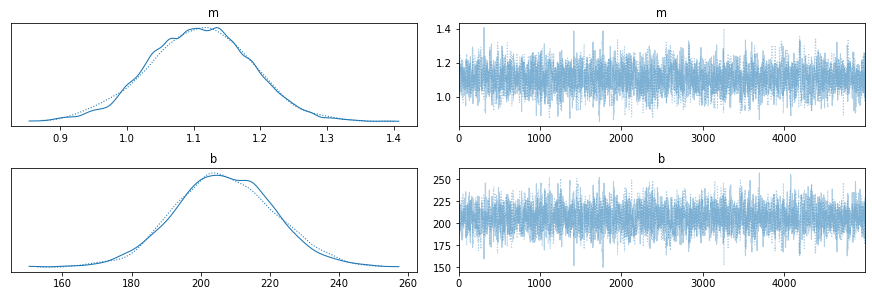

In [9]:
# You could use matplotlib and look at each variable in your chain
# but arviz is much more user friendly and lets you do traceplots quickly
import arviz
arviz.plot_trace(samples_ols)

# If your traceplot looks ok, get some summary statistics from your trace

In [10]:
# you could also do something like np.percentile(samples_ols['m'], [16, 50, 84]) to get statistics
# but arviz is really user friendly so:
arviz.summary(samples_ols)

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,1.109,0.077,0.964,1.256,0.002,0.001,2158.0,2150.0,2166.0,2081.0,1.0
b,206.873,14.400,180.560,234.548,0.311,0.220,2151.0,2151.0,2156.0,2252.0,1.0


# Now lets see how if our data looks anything like data generated from the model suggest

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


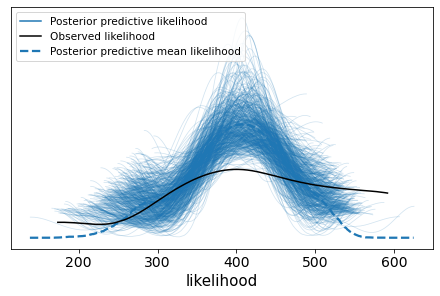

In [11]:
# RUN THIS
ppc = pm.sample_posterior_predictive(samples_ols, samples=500, model=model)
arviz.plot_ppc(arviz.from_pymc3(posterior_predictive=ppc, model=model));

# In-Class Exercise: Let's Look at the resulting fit!

Text(0, 0.5, 'y')

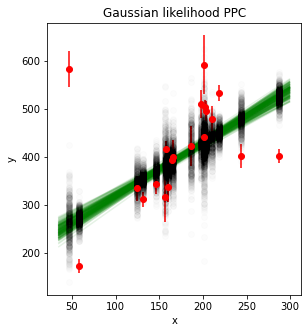

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)

# make plot of original data
ax.errorbar(x, y, yerr=dy, linestyle='None', color='red', marker='o')

# draw 200 random samples from the posteriors (can use np.random.choice to get random integers) 
# and select those m and b values
nsamp = 200
i = np.random.choice(range(samples_ols['m'].shape[0]), size=nsamp)
m = samples_ols['m'][i]
b = samples_ols['b'][i]

# plot the y = mx + b lines from your samples
xarr = np.array([xmin, xmax])
for mx, bx in zip(m, b):
    ax.plot(xarr, mx*xarr + bx, alpha=0.1, color='green')

# plot the posterior predictive samples for the Gaussian
for i in range(ppc['likelihood'].shape[0]):
    ymod = ppc['likelihood'][i,:]
    ax.plot(x, ymod, 'ko', alpha=0.01)

ax.set_title('Gaussian likelihood PPC')
ax.set_xlabel('x')
ax.set_ylabel('y')


# In-Class Exercise: Student-T likelihood

Next we're going to try an alternative model, where our likelihood is a Student-T distribution rather than a Normal one. The Student-T has fatter tails than a Gaussian, so there is a higher probability of points being farther out - i.e. it's resilient to outliers. (remember on of our first in-class exercises). 

It is characterized by a number of degrees of freedom, $nu$. This is *NOT* the number of degrees of freedom of the problem but rather a nuisance parameter that allows the tails of the distribution to be thinner/fatter.

Since this is a parameter, it needs a prior. It can't be less that 0 (or really less than 1, where the Student-T has infinite variance). We also know that $nu$ can't be really high, because in that limit the Student-T looks like a Gaussian, which would imply no outliers, and we know there are from just *looking at the data*. 

I picked a HalfCauchy distribution - you can pick something else if you like. Also note that because the slope isn't negative, we could use a Half-normal if we like. Half-Normals are defined like a Normal centered at 0 with the left half truncated, which isn't what we want, but we can add a bound to a standard normal distribution with some $\mu$ - I've bounded it at 2 in this example.

In [16]:
import theano.tensor as tt

with pm.Model() as model2:
    # write down expressions for the priors on the slope and intercept of the line 
    
    # https://docs.pymc.io/api/distributions/continuous.html
    # they are all in the form of 
    # Distribution('variable name', parameters of distribution)
    # e.g. Normal('blah', mu=0, sigma=1)
    
    b = pm.Normal('b', mu=60, sigma=70)
    
    # If we want the distribution bounded, we can use pm.Bound
    # m = pm.Bound(pm.Normal, lower=2)('m', ...)
    m = pm.Bound(pm.Normal, lower=2)('m', mu=2.0, sigma=5.0)

    # We also need our prior on nu...
    # nu = pm.HalfCauchy('nu',...)
    nu = pm.HalfCauchy('nu', beta=3)

    # write down your model
    ymod = m*x + b
    
    # and write down your likelihood function
    # pymc3 accepts keywords, observed for the data
    # I suggest: likelihood = pm.StudentT('likelihoodT',...
    likelihood = pm.StudentT('likelihoodT', mu=ymod, nu=nu, sigma=dy, observed=y)

    
    # and then to sample!
    samples_T = pm.sample(5000, cores=2) # draw 5000 posterior samples 

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, m, b]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6902861031166534, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7160816074036974, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


### Note how the posterior distribution in the slope $m$ looks now using plot_trace! 

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>]], dtype=object)

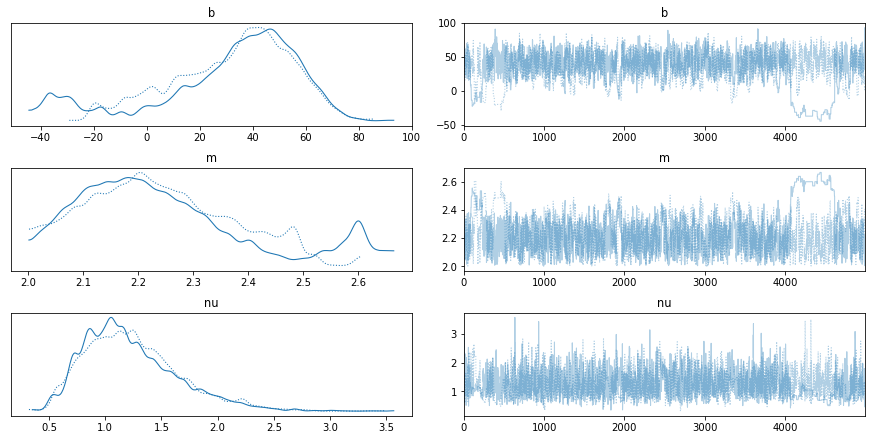

In [17]:
# YOUR CODE HERE
arviz.plot_trace(samples_T)

### As before, generate posterior predictive samples - i.e. samples that are generated, drawing from the posterior distribution.

In [18]:
# YOUR CODE HERE
ppcT = pm.sample_posterior_predictive(samples_T, samples=500, model=model2)

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


### As for the Gaussian case, plot the student-T likelihood fits for the fits and compare to its performance relative to the Gaussian

(120.67707822010254, 621.2866814180012)

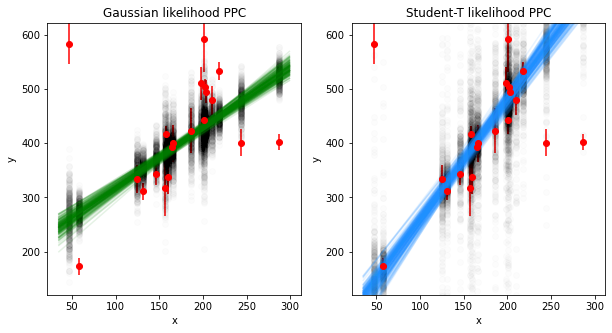

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax, sharey=ax)


# draw 200 random samples from the posteriors
nsamp = 200
i = np.random.choice(range(samples_ols['m'].shape[0]), size=nsamp)
m = samples_ols['m'][i]
b = samples_ols['b'][i]

m2 = samples_T['m'][i]
b2 = samples_T['b'][i]

# plot the posterior predictive samples for the Gaussian
for i in range(ppc['likelihood'].shape[0]):
    ymod = ppc['likelihood'][i,:]
    ax.plot(x, ymod, 'ko', alpha=0.01)
    
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
  
# plot the posterior predictive samples for the student T
for i in range(ppcT['likelihoodT'].shape[0]):
    ymod = ppcT['likelihoodT'][i,:]
    ax2.plot(x, ymod, 'ko', alpha=0.01) 

xarr = np.array([xmin, xmax])
for mx, bx in zip(m, b):
    ax.plot(xarr, mx*xarr + bx, alpha=0.1, color='green')
    
for mx, bx in zip(m2, b2):
    ax2.plot(xarr, mx*xarr + bx, alpha=0.1, color='dodgerblue')
    
    
ax.errorbar(x, y, yerr=dy, linestyle='None', color='red', marker='o')
ax2.errorbar(x, y, yerr=dy, linestyle='None', color='red', marker='o')

ax.set_title('Gaussian likelihood PPC')
ax2.set_title('Student-T likelihood PPC')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax2.set_ylim([ymin, ymax])

### You should be able to see that the posterior predictive samples from the Student-T model are a much better match to the real observations - there's more outliers, like we actually get, but they don't weight the fit as much so the slope is more reasonable. 